# Dimension reduction

In [1]:
# %load /home/dan/.jupyter/firstcell.py 
%load_ext autoreload
%autoreload 2

import sys
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

font = {'size'   : 14}
mpl.rc('font', **font)

import numpy as np
import pandas as pd

from scipy import stats
import sklearn



In [ ]:
# You will need to install PHATE and scprep to run this. You can use:
# !pip install --user -U phate scprep

In [2]:
# %load /home/dan/.jupyter/sc.py
import phate
import umap
import scprep

from sklearn.decomposition import PCA


#### Load preprocessed genotype matrix

In [3]:
d = np.load('../data/transposed_genotype_matrix.npz', allow_pickle=True)

In [4]:
# Assign colours to each ethnicity, roughly themed according to continent
# The Category20b palette has a bunch of groups of 4 shades in the same colour range
color_dict = {'CDX': '#393b79',
 'CHB': '#5254a3',
 'JPT': '#6b6ecf',
 'KHV': '#9c9ede',
 'CHS': '#9e9ac8',
 'BEB': '#637939',
 'GIH': '#8ca252',
 'ITU': '#b5cf6b',
 'PJL': '#cedb9c',
 'STU': '#c7e9c0',
 'ASW': '#8c6d31',
 'ACB': '#bd9e39',
 'ESN': '#e7ba52',
 'GWD': '#e7cb94',
 'LWK': '#7f3b08',
 'MSL': '#b35806',
 'YRI': '#e08214',
 'GBR': '#843c39',
 'FIN': '#ad494a',
 'IBS': '#d6616b',
 'TSI': '#e7969c',
 'CEU': '#d6604d',
 'CLM': '#7b4173',
 'MXL': '#a55194',
 'PEL': '#ce6dbd',
 'PUR': '#de9ed6'}

In [5]:
transposed_genotype_matrix = d['transposed_genotype_matrix']
pop_labels = d['pop_labels']

### PCA

#### Calc PCA coordinates

In [6]:
pc_op = PCA().fit(transposed_genotype_matrix)

In [7]:
data_pca = pc_op.transform(transposed_genotype_matrix)

#### PCA scree plot

I'm a little shocked that there's so little variance past PC4, but only 17% of the variance is contained in these PCs. I guess this is standard for genotype data?

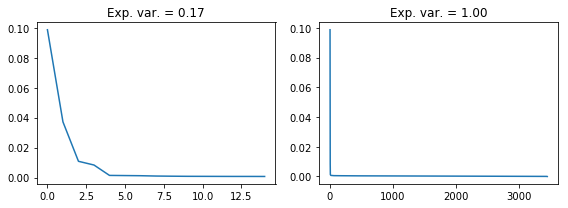

In [8]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

axes[0].plot(pc_op.explained_variance_ratio_[:15])
axes[0].set_title('Exp. var. = {:.2f}'.format(np.sum(pc_op.explained_variance_ratio_[:15])))
axes[1].plot(pc_op.explained_variance_ratio_)

axes[1].set_title('Exp. var. = {:.2f}'.format(np.sum(pc_op.explained_variance_ratio_)))

fig.tight_layout()

### Running PHATE and UMAP

Running both methods with default parameters and using pca-reduced data

In [9]:
# Note, by default PHATE only considers the first 100 PCs prior to reduction
data_phate = phate.PHATE(verbose=False).fit_transform(transposed_genotype_matrix)

data_phate_pc15 = phate.PHATE(n_pca=15, verbose=False).fit_transform(transposed_genotype_matrix)

data_phate_pc1k = phate.PHATE(n_pca=1000, verbose=False).fit_transform(transposed_genotype_matrix)

In [10]:
data_umap = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5).fit_transform(transposed_genotype_matrix)

data_umap_pc15 = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5).fit_transform(data_pca[:,:15])

data_umap_pc1k = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5).fit_transform(data_pca[:,:1000])

/home/dan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
/home/dan/.local/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components
/usr/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


#### Comparing both methods run with default parameters using population color scheme

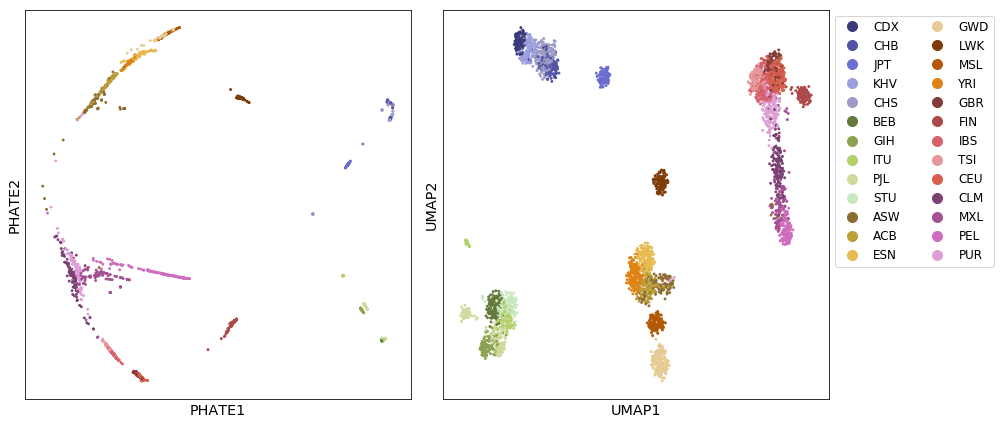

In [11]:
fig, axes = plt.subplots(1,2, figsize=(14,6))

scprep.plot.scatter2d(data_phate, c=pop_labels, cmap=color_dict, 
                      ticks=False, label_prefix='PHATE', ax=axes[0], legend=False)

scprep.plot.scatter2d(data_umap, c=pop_labels, cmap=color_dict, 
                      ticks=False, label_prefix='UMAP', ax=axes[1],legend_anchor=(1,1))

fig.tight_layout()
fig.savefig('../img/PHATE_vs_UMAP.pop.png', dpi=300)

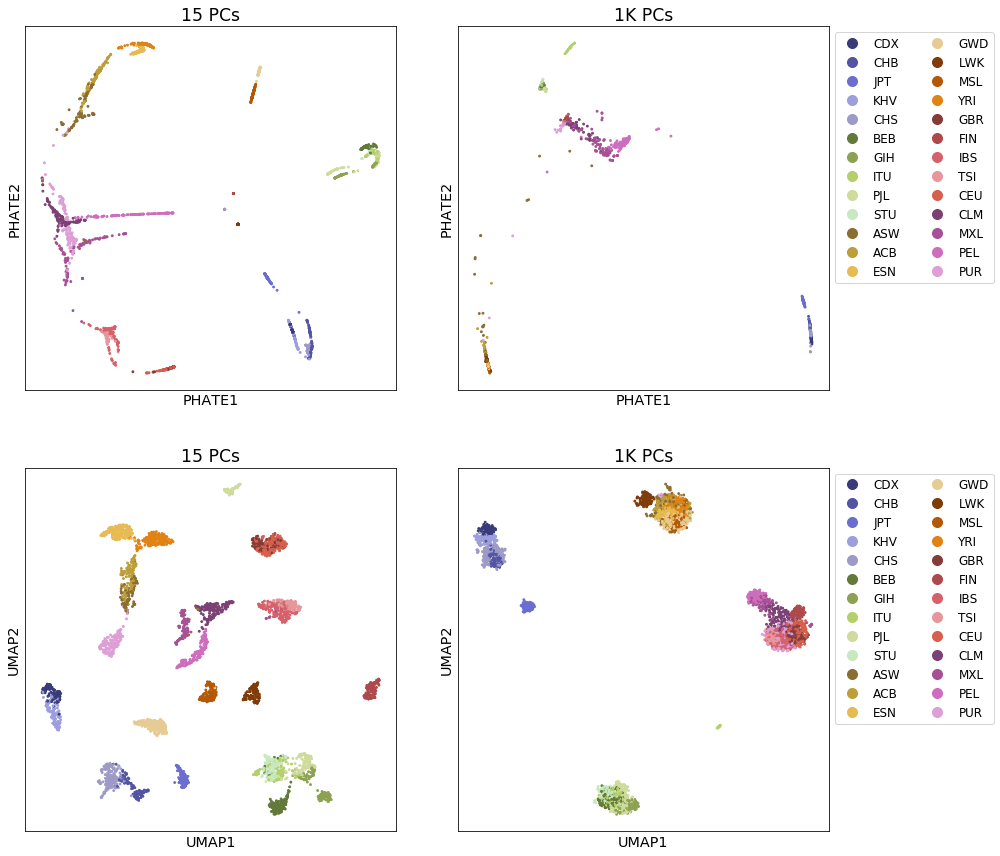

In [12]:
fig, axes = plt.subplots(2,2, figsize=(14,12))

scprep.plot.scatter2d(data_phate_pc15, c=pop_labels, cmap=color_dict, 
                      ticks=False, label_prefix='PHATE', ax=axes[0,0], title='15 PCs', 
                      legend=False)

scprep.plot.scatter2d(data_phate_pc1k, c=pop_labels, cmap=color_dict, 
                      ticks=False, label_prefix='PHATE', ax=axes[0,1],  title='1K PCs',
                      legend_anchor=(1,1))


scprep.plot.scatter2d(data_umap_pc15, c=pop_labels, cmap=color_dict, 
                      ticks=False, label_prefix='UMAP', ax=axes[1,0], title='15 PCs', 
                      legend=False)

scprep.plot.scatter2d(data_umap_pc1k, c=pop_labels, cmap=color_dict, 
                      ticks=False, label_prefix='UMAP', ax=axes[1,1],  title='1K PCs',
                      legend_anchor=(1,1))

fig.tight_layout(w_pad=4,h_pad=4)
fig.savefig('../img/PHATE_vs_UMAP.n_pca.pop.png', dpi=300)

#### Looking at the ASW population

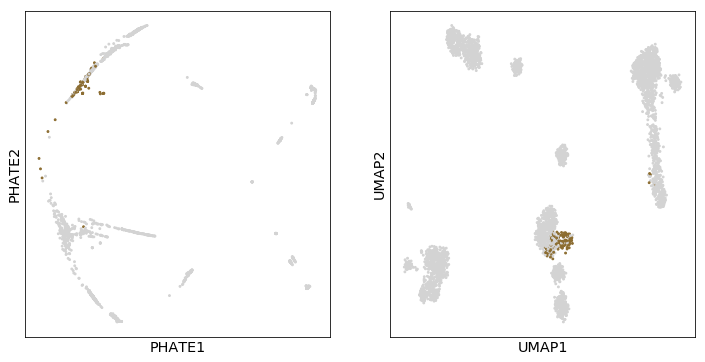

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

#Only show the color if the pop label == 'ASW'
is_asw_cmap = {pop:color_dict[pop] if pop == 'ASW' else 'lightgrey' for pop in color_dict}

scprep.plot.scatter2d(data_phate, c=pop_labels, cmap=is_asw_cmap,
                      ticks=False, label_prefix='PHATE', ax=axes[0], legend=False)

scprep.plot.scatter2d(data_umap,  c=pop_labels, cmap=is_asw_cmap,
                      ticks=False, label_prefix='UMAP', ax=axes[1], legend=False)

#### Examining PC loadings on the PHATE plot

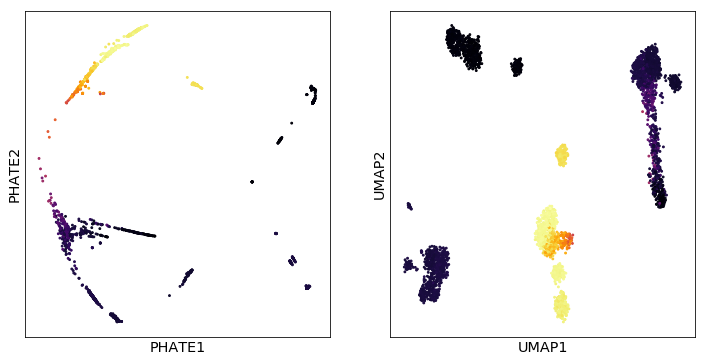

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

scprep.plot.scatter2d(data_phate, c=data_pca[:,0],
                      ticks=False, label_prefix='PHATE', ax=axes[0], legend=False)

scprep.plot.scatter2d(data_umap,  c=data_pca[:,0],
                      ticks=False, label_prefix='UMAP', ax=axes[1], legend=False)

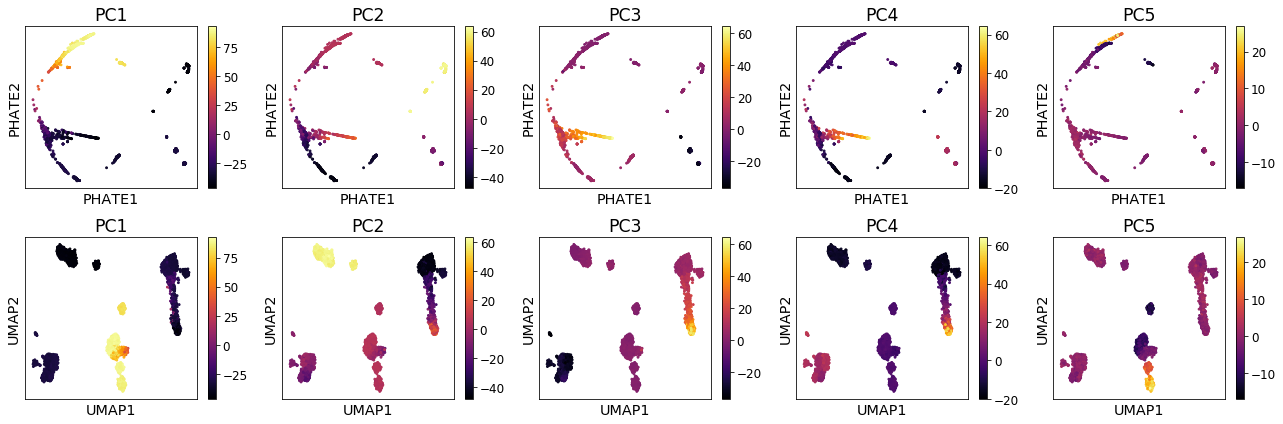

In [15]:
fig, axes = plt.subplots(2,5, figsize=(18,6))

for i in range(5):
    scprep.plot.scatter2d(data_phate, c=data_pca[:,i],
                      ticks=False, label_prefix='PHATE', ax=axes[0,i], legend=True,
                         title='PC{}'.format(i+1))

    scprep.plot.scatter2d(data_umap,  c=data_pca[:,i],
                      ticks=False, label_prefix='UMAP', ax=axes[1,i],legend_anchor=(1,1),
                         title='PC{}'.format(i+1))
    
fig.tight_layout()
fig.savefig('../img/PHATE_vs_UMAP.pcs.1-5.png', dpi=300)

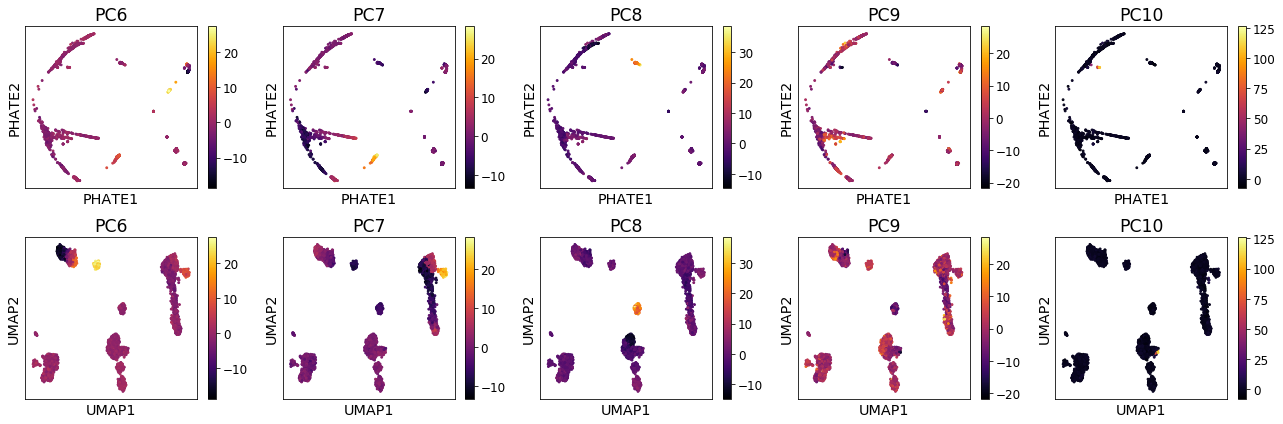

In [16]:
fig, axes = plt.subplots(2,5, figsize=(18,6))

for i in range(5):
    scprep.plot.scatter2d(data_phate, c=data_pca[:,i+5],
                      ticks=False, label_prefix='PHATE', ax=axes[0,i], legend=True,
                         title='PC{}'.format(i+6))

    scprep.plot.scatter2d(data_umap,  c=data_pca[:,i+5],
                      ticks=False, label_prefix='UMAP', ax=axes[1,i],legend_anchor=(1,1),
                         title='PC{}'.format(i+6))
    
fig.tight_layout()
fig.savefig('../img/PHATE_vs_UMAP.pcs.6-10.png', dpi=300)